In [8]:

import h5py
import numpy as np
import os
import pickle

# Method to load all the data from given roots and return arrays for it
def load_data(roots, demos_to_use=[]):
    roots = sorted(roots)

    tactile_indices = [] 
    allegro_indices = []
    allegro_action_indices = [] 
    kinova_indices = []
    image_indices = []
    
    tactile_values = {}
    allegro_tip_positions = {} 
    allegro_actions = {}
    kinova_states = {}

    for demo_id,root in enumerate(roots): 
        demo_num = int(root.split('/')[-1].split('_')[-1])
        if (len(demos_to_use) > 0 and demo_num in demos_to_use) or (len(demos_to_use) == 0): # If it's empty then it will be ignored
            with open(os.path.join(root, 'tactile_indices.pkl'), 'rb') as f:
                tactile_indices += pickle.load(f)
            with open(os.path.join(root, 'allegro_indices.pkl'), 'rb') as f:
                allegro_indices += pickle.load(f)
            with open(os.path.join(root, 'allegro_action_indices.pkl'), 'rb') as f:
                allegro_action_indices += pickle.load(f)
            with open(os.path.join(root, 'kinova_indices.pkl'), 'rb') as f:
                kinova_indices += pickle.load(f)
            with open(os.path.join(root, 'image_indices.pkl'), 'rb') as f:
                image_indices += pickle.load(f)

            # Load the data
            with h5py.File(os.path.join(root, 'allegro_fingertip_states.h5'), 'r') as f:
                allegro_tip_positions[demo_id] = f['positions'][()]
            with h5py.File(os.path.join(root, 'allegro_commanded_joint_states.h5'), 'r') as f:
                allegro_actions[demo_id] = f['positions'][()] # Positions are to be learned - since this is a position control
            with h5py.File(os.path.join(root, 'touch_sensor_values.h5'), 'r') as f:
                tactile_values[demo_id] = f['sensor_values'][()]
            with h5py.File(os.path.join(root, 'kinova_cartesian_states.h5'), 'r') as f:
                state = np.concatenate([f['positions'][()], f['orientations'][()]], axis=1)     
                kinova_states[demo_id] = state

    data = dict(
        tactile = dict(
            indices = tactile_indices,
            values = tactile_values
        ),
        allegro_states = dict(
            indices = allegro_indices, 
            values = allegro_tip_positions
        ),
        allegro_actions = dict(
            indices = allegro_action_indices,
            calues = allegro_actions
        ),
        kinova = dict( 
            indices = kinova_indices, 
            values = kinova_states
        ), 
        image = dict( 
            indices = image_indices
        )
    )

    return data


In [9]:
# Script to run byol training on the images
# Get a root to have the data and get the images from there
# Implement a dataset to get every part of the data
# Train a byol with different resnets

roots = [
    '/home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/demonstration_5'
]



In [10]:
data = load_data(roots)

USING DEMO: 5 [DEMO_ID: 0 - IN ROOT: /home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/demonstration_5


In [62]:
from copy import deepcopy
import glob
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import torch
import torchvision.transforms as T 
import torch.nn.functional as F

from torchvision.datasets.folder import default_loader as loader 
from torch.utils import data
from tqdm import tqdm
from omegaconf import DictConfig, OmegaConf

from torchvision.transforms.functional import crop
def crop_transform(image):
    return crop(image, 0,0,480,480)

# Class for tactile and camera image dataset
class TactileVisionDataset(data.Dataset):
    def __init__(
        self,
        data_path,
        vision_stats=[], # Will have image means and stds
        normalize=False
    ):
        super().__init__()
        self.roots = glob.glob(f'{data_path}/demonstration_*')
        self.roots = sorted(self.roots)

        self.data = load_data(self.roots, demos_to_use=[])

        vision_transforms = [
            T.Resize((480,640)),
            T.Lambda(crop_transform),
            T.ToTensor()
        ]
        if normalize:
            vision_transforms.append(
                T.Normalize(vision_stats[0], vision_stats[1])
            )
        self.vision_transform = T.Compose(vision_transforms)
        self.tactile_transform = T.Resize((16,16))

    def __len__(self):
        return len(self.data['tactile']['indices'])

    def _get_image(self, demo_id, image_id):
        image_root = self.roots[demo_id]
        image_path = os.path.join(image_root, 'cam_0_rgb_images/frame_{}.png'.format(str(image_id).zfill(5)))
        img = self.vision_transform(loader(image_path))
        return torch.FloatTensor(img)

    def _get_tactile_image(self, tactile_values): # shape: 15,16,3
        tactile_image = torch.FloatTensor(tactile_values) 
        tactile_image = F.pad(tactile_image, (0,0,0,0,1,0), 'constant', 0) # pads it to 16,16,3 by concatenating 0z
        tactile_image = tactile_image.view(16,4,4,3)

        tactile_image = torch.concat([
            torch.concat([tactile_image[i*4+j] for j in range(4)], dim=0)
            for i in range(4)
        ], dim=1)
        tactile_image = torch.permute(tactile_image, (2,0,1))

        return self.tactile_transform(tactile_image)

    def __getitem__(self, index):
        demo_id, tactile_id = self.data['tactile']['indices'][index]
        _, image_id = self.data['image']['indices'][index]

        # Get the tactile image
        tactile_values = self.data['tactile']['values'][demo_id][tactile_id]
        tactile_image = self._get_tactile_image(tactile_values)

        # Get the camera image
        image = self._get_image(demo_id, image_id)

        return tactile_image, image

    def getitem(self, index):
        return self.__getitem__(index) # NOTE: for debugging purposes

In [63]:
from torchvision.transforms.functional import crop
def crop_transform(image):
    return crop(image, 0,0,480,480)

In [72]:

class VisionDataset(data.Dataset):
    def __init__(
        self,
        data_path
    ):
        super().__init__()
        self.roots = glob.glob(f'{data_path}/demonstration_*')
        self.roots = sorted(self.roots)

        self.data = load_data(self.roots, demos_to_use=[])['image']

        self.vision_transform = T.Compose([
            T.Resize((480,640)),
            T.Lambda(crop_transform),
            T.ToTensor(),
            T.Normalize((0,0,0), (1,1,1))
        ])

    def __len__(self):
        return len(self.data['indices'])

    def _get_image(self, demo_id, image_id):
        image_root = self.roots[demo_id]
        image_path = os.path.join(image_root, 'cam_0_rgb_images/frame_{}.png'.format(str(image_id).zfill(5)))
        img = self.vision_transform(loader(image_path))
        return torch.FloatTensor(img)

    def __getitem__(self, index):
        demo_id, image_id = self.data['indices'][index]

        # Get the camera image
        image = self._get_image(demo_id, image_id)

        return image

    def getitem(self, index):
        return self.__getitem__(index) # NOTE: for debugging purposes

In [73]:
from torchvision import models

# Script to return all pretrained models in torchvision.models module
def resnet18(pretrained : bool):
    if pretrained:
        return models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    return models.resnet18()

def resnet34(pretrained : bool):
    if pretrained:
        return models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    return models.resnet34()

In [74]:
encoder = resnet18(True)

mod_name: collections, name: OrderedDict
mod_name: torch._utils, name: _rebuild_parameter
mod_name: torch._utils, name: _rebuild_tensor_v2


USING DEMO: 1 [DEMO_ID: 0 - IN ROOT: /home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/demonstration_1
USING DEMO: 10 [DEMO_ID: 1 - IN ROOT: /home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/demonstration_10
USING DEMO: 11 [DEMO_ID: 2 - IN ROOT: /home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/demonstration_11
USING DEMO: 12 [DEMO_ID: 3 - IN ROOT: /home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/demonstration_12
USING DEMO: 13 [DEMO_ID: 4 - IN ROOT: /home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/demonstration_13
USING DEMO: 14 [DEMO_ID: 5 - IN ROOT: /home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/demonstration_14
USING DEMO: 15 [DEMO_ID: 6 - IN ROOT: /home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/demonstration_15
USING DE

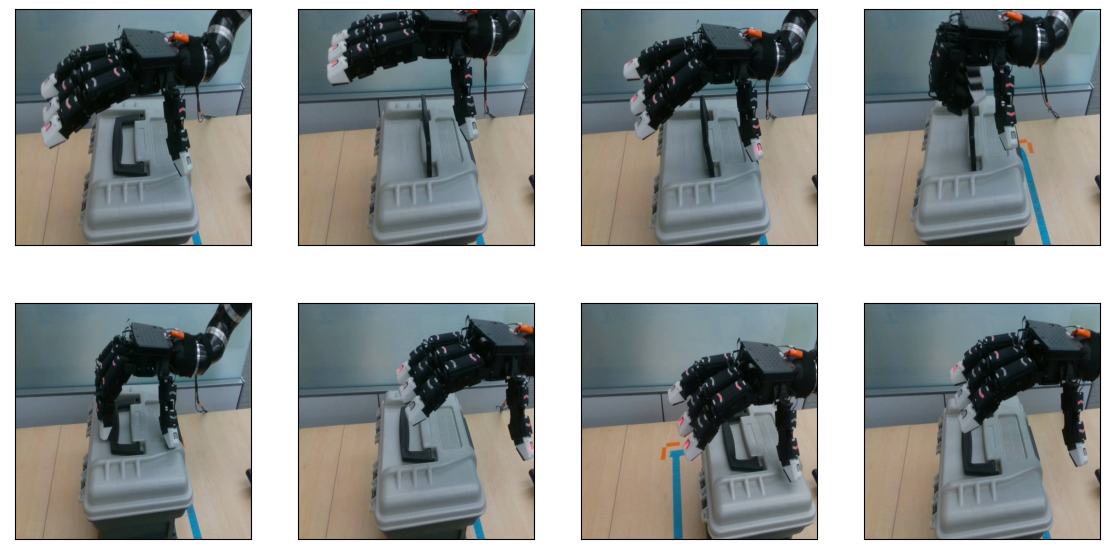

In [75]:
####### EXAMINE SAMPLE BATCH

# dataset
image_dataset = VisionDataset(data_path = '/home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing')

# data loader
image_loader = data.DataLoader(image_dataset, 
                                batch_size  = 32, 
                                shuffle     = True, 
                                num_workers = 4,
                                pin_memory  = True)

# display images
for batch_idx, inputs in enumerate(image_loader):
    fig = plt.figure(figsize = (14, 7))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
    break

In [76]:
def get_image_stats(image_loader):
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    # loop through images
    for inputs in tqdm(image_loader):
        psum    += inputs.sum(axis = [0, 2, 3])
        psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

    # pixel count
    count = len(image_dataset) * 480 * 480

    # mean and std
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    # output
    print('mean: '  + str(total_mean))
    print('std:  '  + str(total_std))

    return [total_mean, total_std]
        

In [77]:
vision_stats = get_image_stats(image_loader)

100%|██████████| 482/482 [01:27<00:00,  5.51it/s]

mean: tensor([0.4191, 0.4445, 0.4409])
std:  tensor([0.2108, 0.1882, 0.1835])


In [78]:

import torch.nn as nn

def get_vision_augmentations(img_means, img_stds, img_size):
    color_aug = T.Compose([
        T.RandomApply(
            nn.ModuleList([T.ColorJitter(.8,.8,.8,.2)]), 
            p = 0.2
        ),
        T.RandomGrayscale(p=0.2), 
        T.RandomApply(
            nn.ModuleList([T.GaussianBlur((3, 3), (1.0, 2.0))]), 
            p = 0.2
        ),
        T.Normalize(
            mean = img_means, # NOTE: Wasn't this wrong?
            std =  img_stds
        )
    ])

    return color_aug 



In [79]:
from tactile_learning.models.ssl_wrappers.byol import BYOL
from torch.optim import Adam

img_means = vision_stats[0]
img_stds = vision_stats[1]
image_size = 480

augment_fn = get_vision_augmentations(
    img_means,
    img_stds,
    img_size=(image_size, image_size)
) # One augment_fn is enough (since it will be the same as augment2)
learner = BYOL(
    net = encoder, # I think already existing image size in resnet is 480?
    image_size = image_size,
    augment_fn = augment_fn
)
optimizer = Adam(
    learner.parameters(),
    lr = 1e-2,
    weight_decay = 1e-5
)


In [80]:
# dataset
image_dataset = TactileVisionDataset(
    data_path = '/home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing')

# data loader
image_loader = data.DataLoader(image_dataset, 
                                batch_size  = 32, 
                                shuffle     = True, 
                                num_workers = 4,
                                pin_memory  = True)



USING DEMO: 1 [DEMO_ID: 0 - IN ROOT: /home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/demonstration_1
USING DEMO: 10 [DEMO_ID: 1 - IN ROOT: /home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/demonstration_10
USING DEMO: 11 [DEMO_ID: 2 - IN ROOT: /home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/demonstration_11
USING DEMO: 12 [DEMO_ID: 3 - IN ROOT: /home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/demonstration_12
USING DEMO: 13 [DEMO_ID: 4 - IN ROOT: /home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/demonstration_13
USING DEMO: 14 [DEMO_ID: 5 - IN ROOT: /home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/demonstration_14
USING DEMO: 15 [DEMO_ID: 6 - IN ROOT: /home/irmak/Workspace/Holo-Bot/extracted_data/box_handle_lifting/box_location_changing/demonstration_15
USING DE

In [81]:
pbar = tqdm(total=len(image_loader))
def train_one_epoch(earner, dataloader, optimizer):
    learner.train()
    total_train_loss = 0

    for batch in tqdm(dataloader):
        _, vision_image  = batch
        optimizer.zero_grad()
        # input_data = torch.cat(input_images, dim = 1).to(configs.device)

        # print('input_images.shap: {}'.format(input_images.shape))
        loss = learner(vision_image) 

        loss.backward()
        optimizer.step()
        learner.update_moving_average()

        total_train_loss += loss.item()
        pbar.set_description(f'Train Loss: {loss.item()}')
        pbar.update(1)

    average_train_loss = total_train_loss / len(dataloader)
    return average_train_loss 

average_loss = train_one_epoch(learner, image_loader, optimizer)

 13%|█▎        | 64/482 [23:20<2:32:26, 21.88s/it]4/482 [23:13<2:30:45, 21.64s/it]


KeyboardInterrupt: 

In [ ]:
# TODO: Have the nearest neighbor thingy implemented